# Transfer learning (VGG19) to detect kidney stone in X-rays

## Transfer Learning
Transfer learning focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. 
For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.



## Transfer Learning in Computer Vision
In the field of computer vision, there are a lot of pre-trained convolution networks that are trained on the ImageNet dataset.
These networks use the weights that they learnt during the training on the Imagenet dataset.

<i>Imagenet dataset has 1.4 million labeled images and 1,000 classes.</i>


## Common Pre-trained Nets
Inception <br>
Xception <br>
VGG Family <br>
ResNet <br>

It must be noted that these are the common four classes. However, there are various other models present as well.

# Model development using VGG19

Importing relevant libraries

In [6]:
import os

import numpy as np

from keras import layers, models

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix

import seaborn as sns
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

## Defining the model 

We have used the convolution base of VGG19 i.e. 16 layers and chopped of the three dense layers

Then we have added our own four dense layes on top

Then we have trained both the convolution base and the new classifier jointly

In [3]:
#convolution base of VGG19
conv_base = VGG19(weights='imagenet',
                  include_top=False, #removing the dense layers
                  input_shape=(224,224,3))


model = models.Sequential()
model.add(conv_base)

#Adding our own four dense layers

#First flattening the convolution output
model.add(layers.Flatten())
#Adding a dense layer with 256 neurons
model.add(layers.Dense(256, activation='relu'))
#Adding a dropout layer to minimize overfitting
model.add(layers.Dropout(0.2))
#Adding another dense layer with 120 neurons
model.add(layers.Dense(120, activation='relu'))
#Adding a dropout layer to minimize overfitting
model.add(layers.Dropout(0.2))
#Adding another dense layer with 10 neurons
model.add(layers.Dense(10, activation='relu'))
#Adding a dropout layer to minimize overfitting
# model.add(layers.Dropout(0.2))
#Adding the output layer with two neurons to classify the output as stone or no stone
model.add(layers.Dense(2, activation='sigmoid'))

#compiling the model
model.compile(loss='categorical_crossentropy',  #loss for binary classification
              optimizer=optimizers.RMSprop(0.0001), #RMS optimizer
              metrics=['accuracy'])

#checking the summary
model.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               30840     
                                                                 
 dropout_1 (Dropout)         (None, 120)               0         
                                                         

Image augmentation refers to making multiple images from a given image... This removes the constraint of having less daat

Image geneartor yields images in batches so that they can be processed in paralel. Without them, the training will become very lengthy. 

In [4]:
#directory which contains our data
base_dir = '/content/drive/MyDrive/kidney_stone'
#directory for training data
train_dir = os.path.join(base_dir, 'Train')
#directory for testing data
test_dir = os.path.join(base_dir, 'Test')
#datagenerator for augmenting training data i.e. making more images from the available images.. 
#Although we havent usedaugmentation in this case
train_datagen = ImageDataGenerator(rescale=1./255,   #normalizing the image colors (RGB)  since they have a maximum range of 255
                                   rotation_range=40,
                                  #  width_shift_range=0.2,
                                  #  height_shift_range=0.2,
                                  #  shear_range=0.2,
                                  #  zoom_range=0.2,
                                  #  horizontal_flip=True,
                                  #  fill_mode='nearest',
                                   validation_split=0.2)

#data generator to yield data in batches of 64
#training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    subset='training')
#validation data
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=64,
                                                        class_mode='categorical',
                                                        subset='validation')

Found 1082 images belonging to 2 classes.
Found 270 images belonging to 2 classes.


In [5]:
#training the model
history = model.fit(train_generator,
                    epochs=45,
                    batch_size=64,
                    validation_data=validation_generator)
#saving the model to be used later on
model.save('kidney.h5')

Epoch 1/45
17/17 [==============================] - 277s 15s/step - loss: 0.7044 - accuracy: 0.5296 - val_loss: 0.6901 - val_accuracy: 0.5370
Epoch 2/45
17/17 [==============================] - 41s 2s/step - loss: 0.6949 - accuracy: 0.5305 - val_loss: 0.6920 - val_accuracy: 0.5370
Epoch 3/45
17/17 [==============================] - 41s 2s/step - loss: 0.7000 - accuracy: 0.5250 - val_loss: 0.6912 - val_accuracy: 0.5370
Epoch 4/45
17/17 [==============================] - 41s 2s/step - loss: 0.7005 - accuracy: 0.5370 - val_loss: 0.6921 - val_accuracy: 0.5370
Epoch 5/45
17/17 [==============================] - 41s 2s/step - loss: 0.6927 - accuracy: 0.5287 - val_loss: 0.6920 - val_accuracy: 0.5370
Epoch 6/45
17/17 [==============================] - 41s 2s/step - loss: 0.6889 - accuracy: 0.5453 - val_loss: 0.6928 - val_accuracy: 0.5519
Epoch 7/45
17/17 [==============================] - 42s 2s/step - loss: 0.6939 - accuracy: 0.5268 - val_loss: 0.6934 - val_accuracy: 0.5111
Epoch 8/45
17/17 [

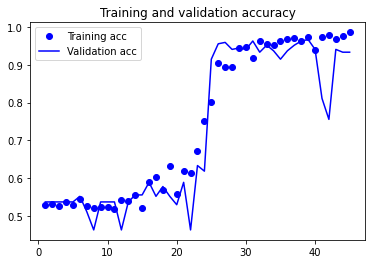

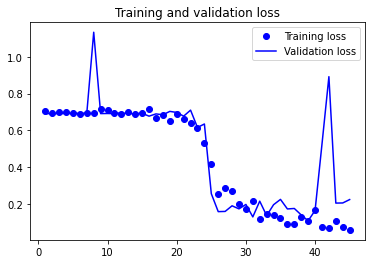

In [6]:
#plotting training and validation accuracy
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
#plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [7]:
#datagenerator for testing data
test_datagen = ImageDataGenerator(rescale=1./255)
#test data
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=100,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 341 images belonging to 2 classes.


In [8]:
#predicting the model for testing data
y_pred= model.predict(test_generator)
#testing labels
y_true= test_generator.classes
#finding confusion matrix for test data
cnf_matrix= confusion_matrix(y_true,y_pred.argmax(axis=1))
print('Confusion Matrix:\n',cnf_matrix)

Confusion Matrix:
 [[156   4]
 [ 10 171]]


In [9]:
#False Positives
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
#False Negatives
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
#True Positives
TP = np.diag(cnf_matrix)
#True Negatives
TN = cnf_matrix.sum() - (FP + FN + TP)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

In [10]:
print('Sensitivity:\n',TPR)
print('Specificity:\n',TNR)
print('Precision:\n',PPV)
print('Overall Accuracy for each class:\n',ACC)

Sensitivity:
 [0.975      0.94475138]
Specificity:
 [0.94475138 0.975     ]
Precision:
 [0.93975904 0.97714286]
Overall Accuracy for each class:
 [0.95894428 0.95894428]


The overall accuracy for both the classes on the test data is 96%

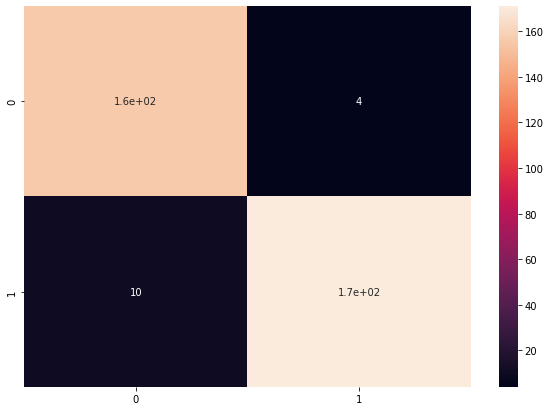

In [11]:
#generating heat map for confusion matrix
plt.figure(figsize = (10,7))
sns.heatmap(cnf_matrix, annot=True)

# Using the model on real world cases

In [3]:
#loading the model
model = load_model("kidney.h5")

Similar image downloaded from Google

Populating the interactive namespace from numpy and matplotlib


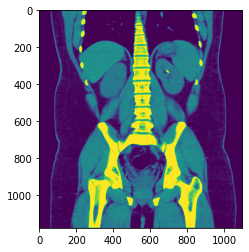

Found 1 images belonging to 1 classes.

 
 Prediction: There is a kidney Stone


In [23]:
#directory of image
img = mpimg.imread('D:/kidney_stone/new_data/Kidney_stone/kidney.png')
#plotting image
imgplot = plt.imshow(img)
plt.show()

#directory of image
bd = 'D:/kidney_stone'
#directory for training data
td = os.path.join(bd, 'new_data')

#datagenerator 
tg = ImageDataGenerator(rescale=1./255)
#training data
tgr = tg.flow_from_directory(td,
                             target_size=(224, 224),
                             batch_size=1,
                             class_mode='categorical')

#making predictions
pred = model.predict(tgr)
pred = pred.reshape(-1)

#the class one refers to KIDNEY STONE and class 2 refers to NO KIDNEY STONE
#if the probability of  class one is higher then it means that there is a kidney stone and vice versa
if pred[0]> pred[1]:
  print('\n \n Prediction: There is a kidney Stone')
else:
  print('\n \n Prediction: There is no kidney stone')